In [182]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# Read data
data_path = "nurse_schedule_project2_data_large_VA.xlsx"
locations = pd.read_excel(data_path, sheet_name="locations", index_col = 0, header = None)
nurses = pd.read_excel(data_path, sheet_name="nurses", index_col = 0)
task_time = pd.read_excel(data_path, sheet_name="task_execution_time", index_col = 0).T

patients = pd.read_excel(data_path, sheet_name="patients", index_col = 0)
# Break comma separated strings into lists
for col in ['M', 'T', 'W','Th','F','S','Su']:
    patients[col] = patients[col].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
for col in ['skillset']:
    nurses[col] = nurses[col].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Transpose the dataframe to access patient information easily
patients = patients.T
nurses = nurses.T


# Sets and Parameters
N = nurses.columns.tolist()            # set of nurses
P = patients.columns.tolist()          # set of patients
L = list(locations.index)         # set of locations
D = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']  # set of days
T_tasks = task_time.columns.tolist() # set of tasks

# Parameters


# define a function to list all patients in a given location
def find_keys_with_inner_value(df, target_value):
    return list(df.T[df.T['location'] == target_value].index)


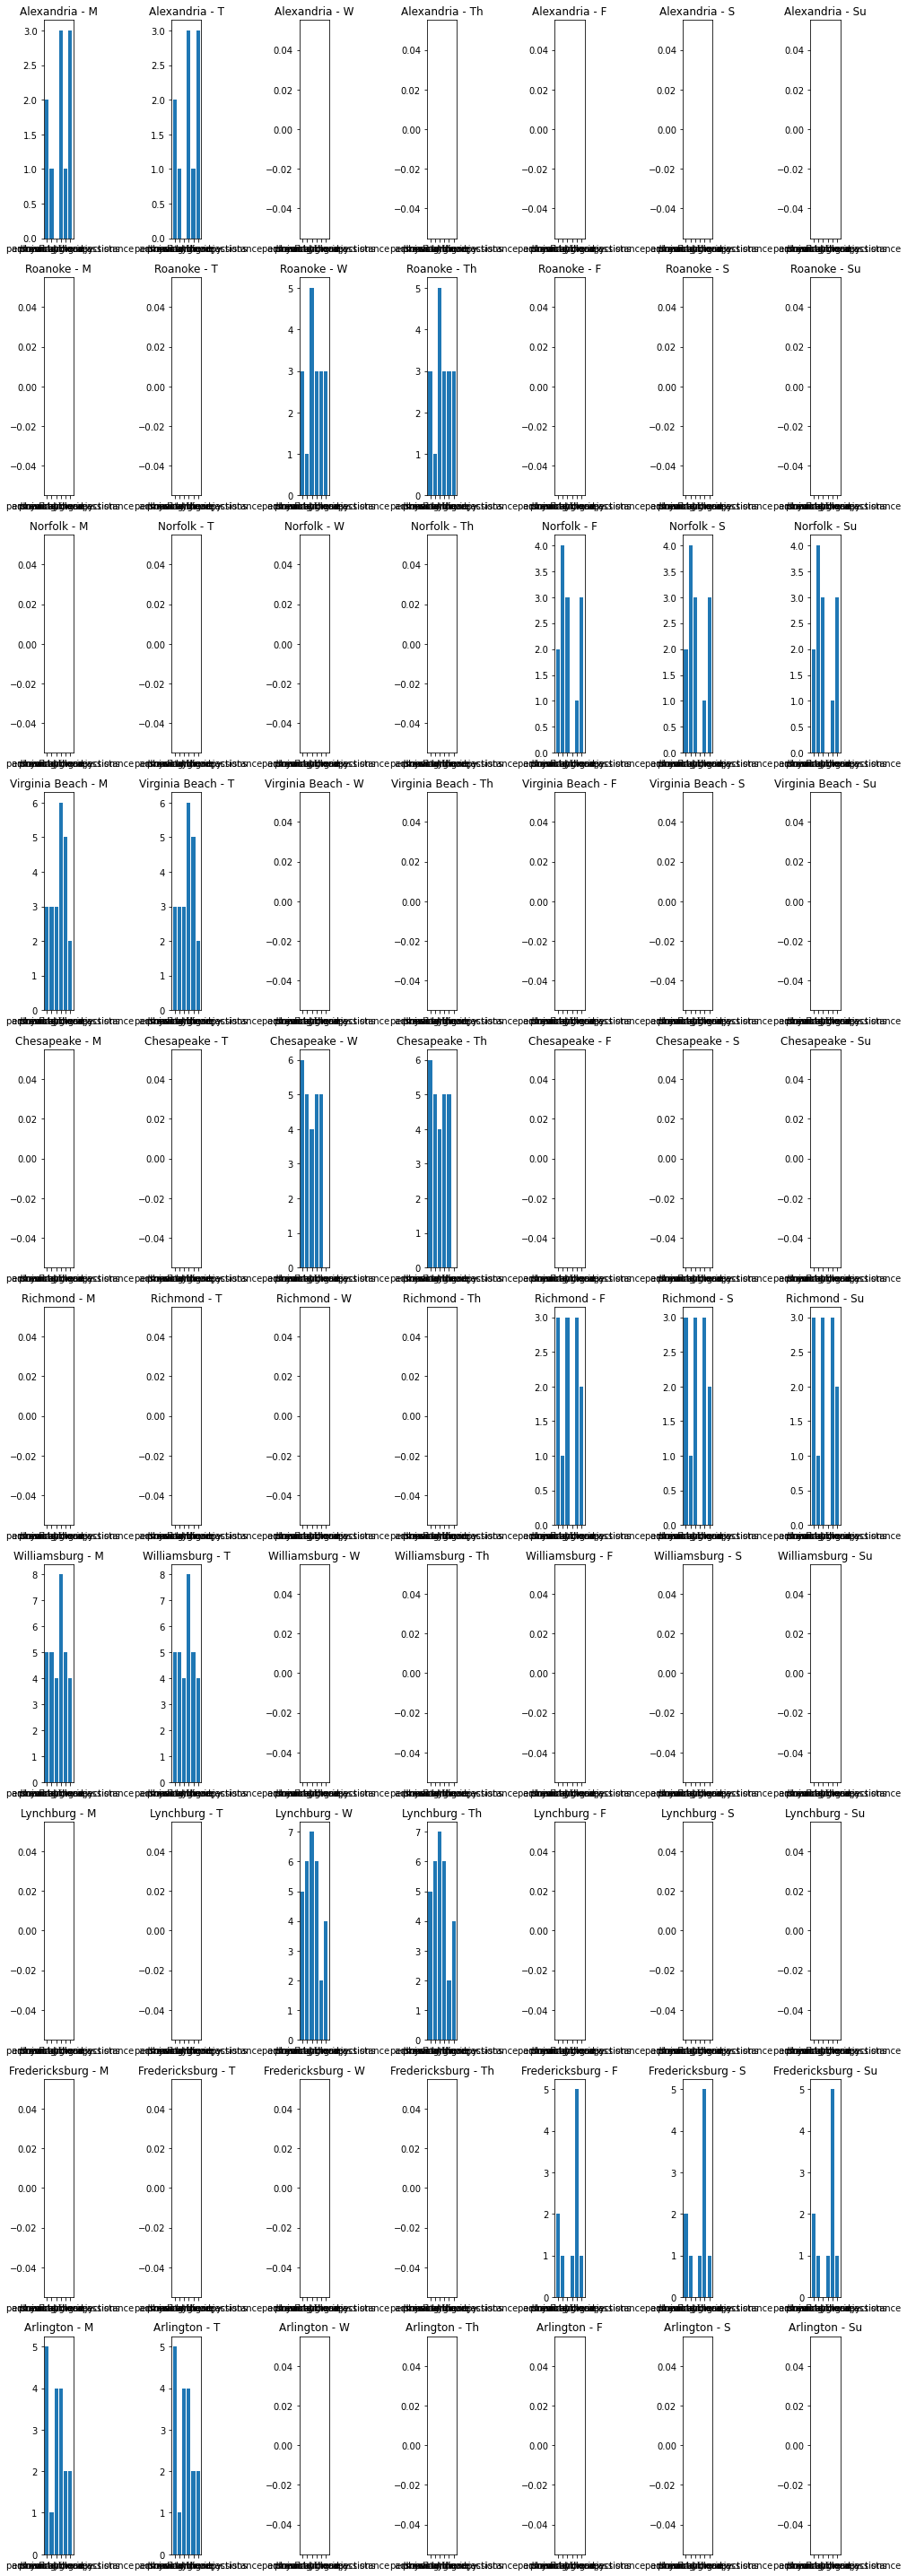

In [176]:
import matplotlib.pyplot as plt

# Sample data

# Count needs by location and day
counts = {location: {day : {need: 0 for need in T_tasks} for day in D} for location in L}

# Assuming counts is a dictionary with the appropriate structure

# Iterate over patient columns in the DataFrame
for patient in patients.columns:
    location = patients[patient]['location']
    
    for day in D:
        for need in T_tasks:
            if need in patients[patient][day]:
                # Increment the need count
                counts[location][day][need] += 1
                

# Plotting
fig, axes = plt.subplots(nrows=len(locations), ncols=7, figsize=(14, len(locations)*4))

for i, location in enumerate(L):
    for j, day in enumerate(D):
        if counts[location][day]:
            names = list(counts[location][day].keys())
            values = list(counts[location][day].values())
            axes[i, j].bar(names, values)
            axes[i, j].set_title(f"{location} - {day}")
        else:
            axes[i, j].set_title(f"{location} - {day}")
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [184]:

# Model
model = gp.Model("Nurse_Scheduling")

# Decision Variables
# x[n,d,p,t] - nurse n on day d does task t for patient p
x = model.addVars(N, D, P, T_tasks, vtype=GRB.BINARY, name="x")

# y[n,l,d] - nurse n works in location l on day d
y = model.addVars(N, L, D, vtype=GRB.BINARY, name="y")



# z[n,l,d] - nurse n is in location l on day d
z = model.addVars(N, L, D, vtype=GRB.BINARY, name="z")

# zd[n,l,d] nurse changes locations on day d.
zd = model.addVars(N, L, D, vtype=GRB.BINARY, name="zd")


R_m = model.addVars(P, D, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="R_m")
R_p = model.addVars(P, D, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="R_p")

#b[n,l] - nurse n 
b = model.addVars(N, L, vtype=GRB.BINARY, name="B")

q = model.addVars(N,  vtype=GRB.BINARY, name="q")

h  = model.addVars(N,D, name="h")

day_worked = model.addVars(N,D, name="day_worked")

change_work = model.addVars(N,D, name="day_worked")

# Define the penalty
penalty_value = -1000
penalized_nurses = ['Nurse_' + str(i) for i in range(10, 19)]

# minimize total number of nurses and changes in locations
model.setObjective(100*sum(q[n] for n in N)+sum(zd[n,l,d] for n in N for l in L for d in D), GRB.MINIMIZE)

# Constraints
model.addConstrs((y[n,l,d] <= day_worked[n,d]) for n in N for l in L for d in D)

model.addConstrs((h[n,d] <= 10*60*day_worked[n,d]) for n in N for d in D)

model.addConstrs(sum(day_worked[n,d] for d in D) <= 4 for n in N)

# Must work consecutive days (but 'S Su M T' is feasible)
for i,d in enumerate(D):
    if i < len(D)-1:
        dNext = D[i+1]
    else:
        dNext = D[0]
    model.addConstrs((day_worked[n,d] - day_worked[n,dNext] <= change_work[n,d]) for n in N for l in L)
    model.addConstrs((day_worked[n,dNext] - day_worked[n,d] <= change_work[n,d]) for n in N for l in L)

model.addConstrs(sum(change_work[n,d] for d in D) <= 2 for n in N)
model.addConstrs((y[n,l,d] <= q[n]) for n in N for l in L for d in D)

# Constraint 1: A nurse can only work at one location on a given day.
model.addConstrs((gp.quicksum(y[n, l, d] for l in L) <= 1 for n in N for d in D), name="C1")

# turn on b[n,l] if a nurse is in that location 
model.addConstrs((z[n,l,d] <= b[n,l]) for n in N for l in L for d in D)

# turn on z[n,l,d] if a nurse works in that location on day d
model.addConstrs((y[n,l,d] <= z[n,l,d]) for n in N for l in L for d in D)

# a nurse must be in exactly one location each day
model.addConstrs((sum(z[n,l,d] for l in L)==1) for n in N for d in D)

# Constraint 2: A nurse can be at a maximum of 2 different locations over all days.
model.addConstrs((gp.quicksum(b[n,l] for l in L) <= 2 for n in N), name="C2")

# zd[n,l,d] = 1 if zd[n,l,d] != zd[n,l,d]
for i,d in enumerate(D[:-1]):
    dNext = D[i+1]
    model.addConstrs((z[n,l,d] - z[n,l,dNext] <= zd[n,l,d]) for n in N for l in L)
    model.addConstrs((z[n,l,dNext] - z[n,l,d] <= zd[n,l,d]) for n in N for l in L)

    
# Constraint 4: The total time a nurse spends on tasks on a given day cannot exceed 10 hours (600 minutes).
model.addConstrs((h[n,d] == gp.quicksum(x[n, d, p, t] * task_time[t]['Time'] for p in P for t in T_tasks) for n in N for d in D), name="C4")
model.addConstrs((h[n,d] <= 10*60 for n in N for d in D), name="C4")

# Constraint 7: Each patient's needs must be met
# This now has a list of differnt needs on different days, and sometimes no needs at all
model.addConstrs((gp.quicksum(x[n, d, p, t] for n in N)>=1  
                 for p in P for d in D for t in patients[p][d]), name="C5")

# Constraint 9: A nurse can only perform tasks that match their skillset.
model.addConstrs((x[n, d, p, t] == 0 for n in N for d in D for p in P for t in T_tasks if t not in nurses[n]['skillset']), name="C9")

# Constraint 10: A nurse can only perform tasks at a location if they are assigned to that location on that day.
model.addConstrs((gp.quicksum(x[n, d, p, t] for p in find_keys_with_inner_value(patients, l) for t in T_tasks) <= (len(find_keys_with_inner_value(patients, l)) * len(T_tasks)+1) * y[n, l, d] for l in L for d in D for n in N), name="C10")

# Constraint 11: A task for a patient can only be assigned to one nurse on a given day.
model.addConstrs((gp.quicksum(x[n, d, p, t] for n in N) <= 1 for d in D for p in P for t in T_tasks), name="C11")




# Solve
#model.setParam("MIPFocus",1)
model.optimize()

# Check the status of the solution
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
elif model.status == GRB.INFEASIBLE:
    print("Model is infeasible.")
elif model.status == GRB.INF_OR_UNBD:
    print("Model is infeasible or unbounded.")
elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded.")
elif model.status == GRB.TIME_LIMIT:
    print("Time limit reached.")
else:
    print("Optimization ended with status", model.status)


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 128013 rows, 223500 columns and 821750 nonzeros
Model fingerprint: 0xb8593c6d
Variable types: 2450 continuous, 221050 integer (221050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 105903 rows and 101064 columns
Presolve time: 2.15s
Presolved: 22110 rows, 122436 columns, 382493 nonzeros
Variable types: 700 continuous, 121736 integer (121429 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.04s

Solved with primal simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 4.091986e+02, 10942 iterations, 0.65 seconds (0.46 w

In [185]:
# Total number of nurses
sum(q[n].x for n in N)

19.0

In [186]:
# Changes in locations
for n in N:
    for l in L:
        w = sum([ zd[n,l,d].x for d in D])
        if w > 0.5:
            print(n,l,[ d  for d in D if zd[n,l,d].x > 0.5] )


Nurse_2 Chesapeake ['T']
Nurse_2 Arlington ['T']
Nurse_7 Chesapeake ['T']
Nurse_7 Arlington ['T']
Nurse_15 Alexandria ['W']
Nurse_15 Norfolk ['W']
Nurse_17 Williamsburg ['T']
Nurse_17 Lynchburg ['T']
Nurse_23 Alexandria ['T']
Nurse_23 Lynchburg ['T']
Nurse_28 Roanoke ['T']
Nurse_28 Virginia Beach ['T']
Nurse_45 Virginia Beach ['T']
Nurse_45 Lynchburg ['T']


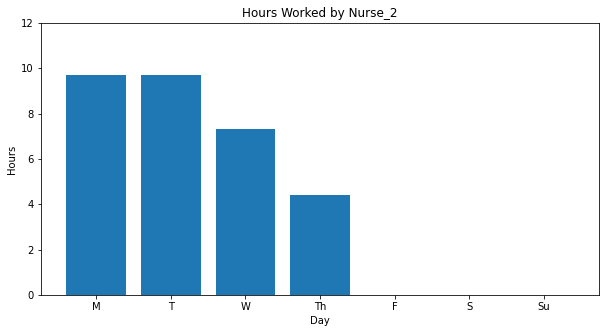

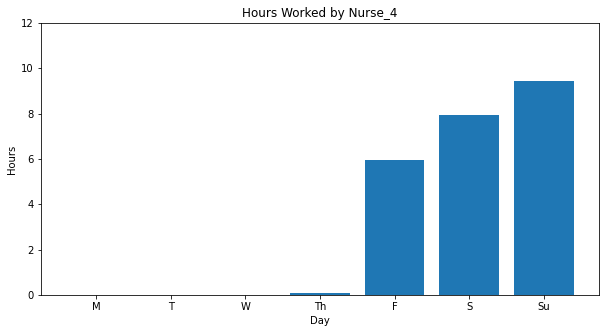

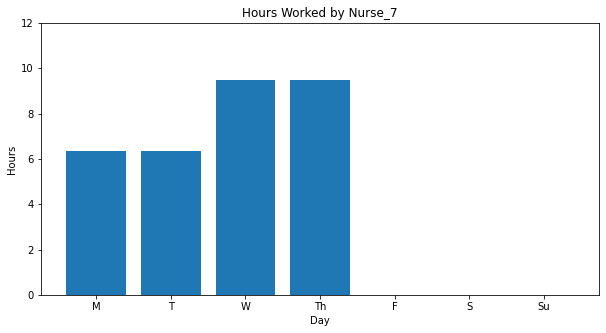

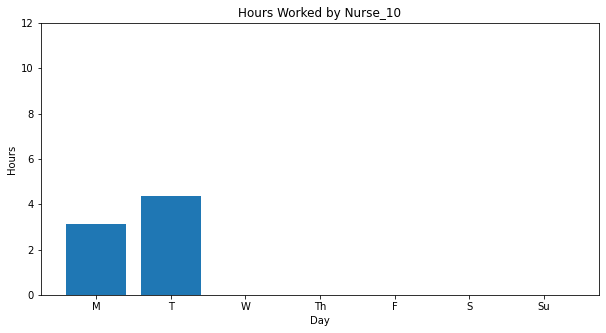

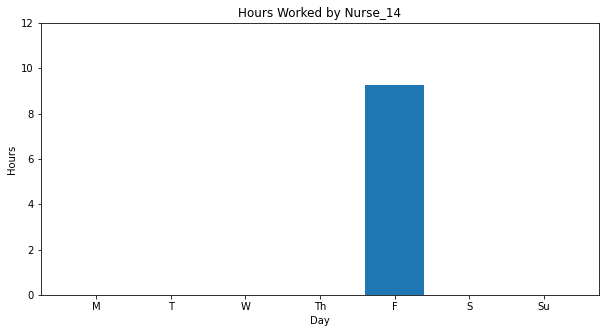

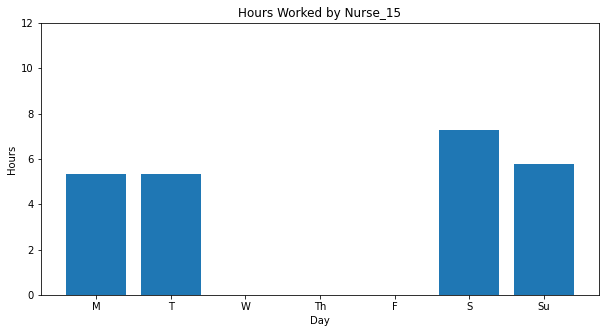

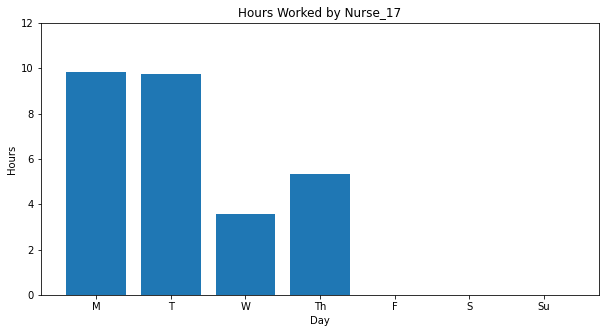

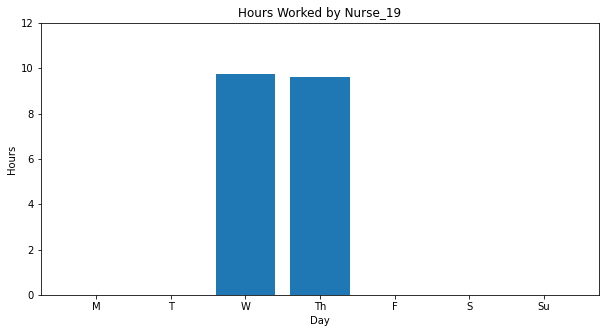

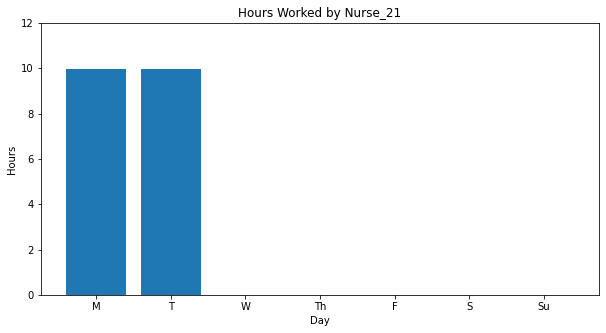

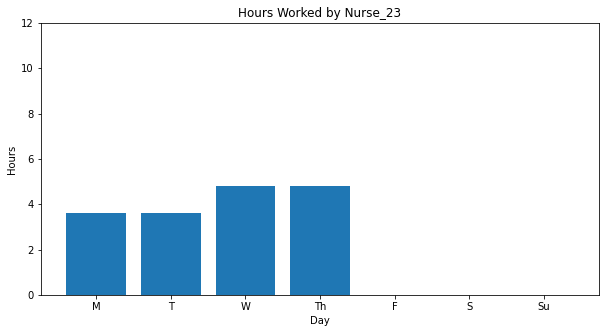

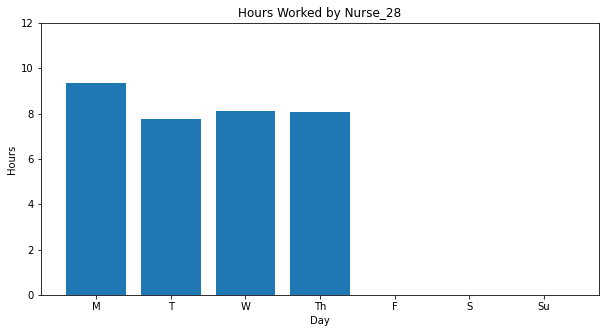

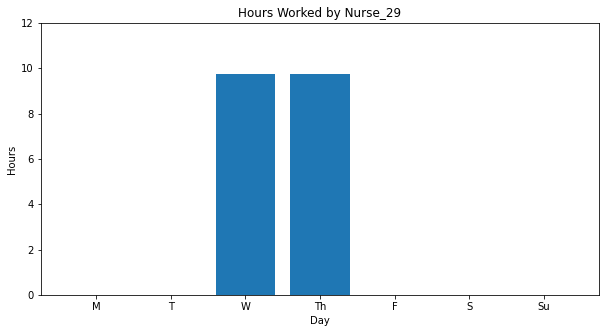

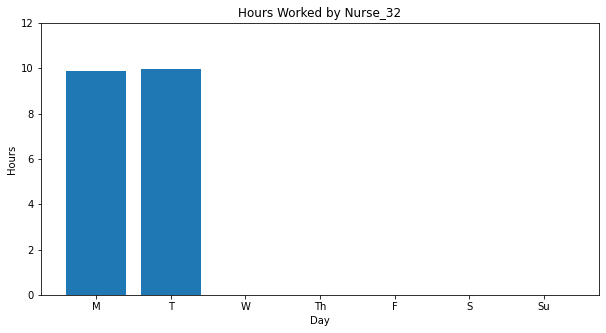

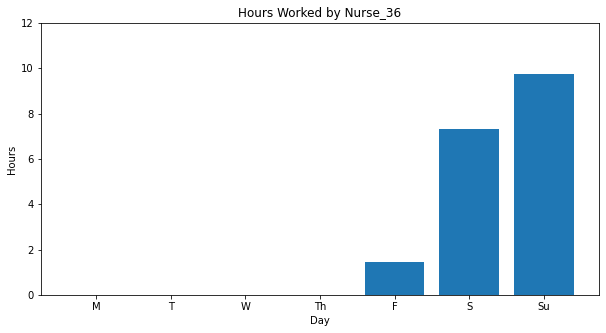

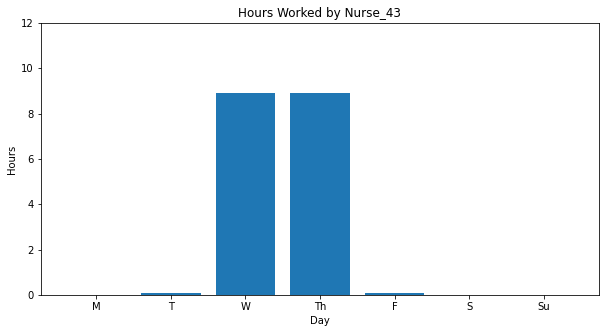

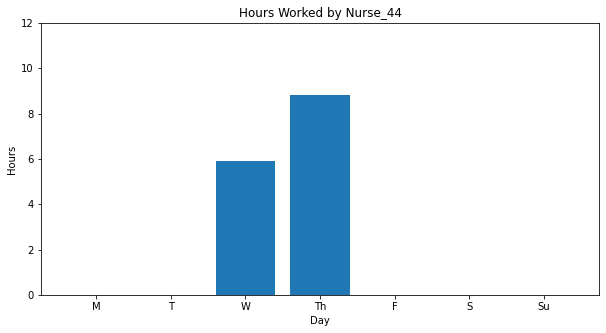

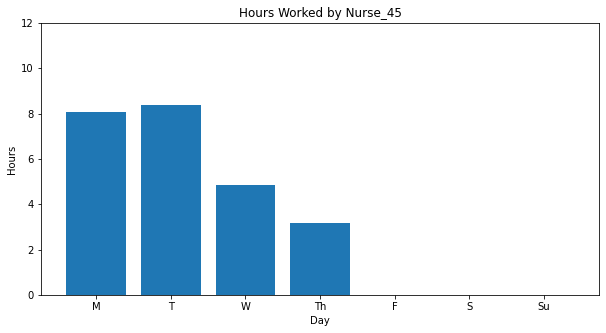

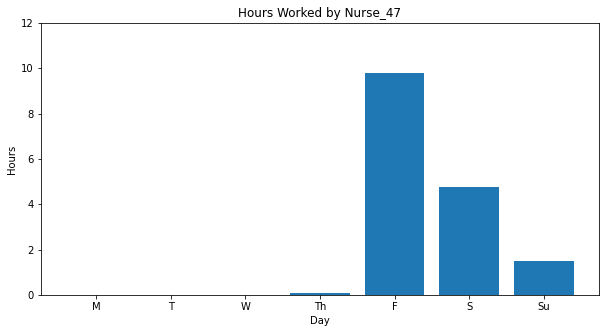

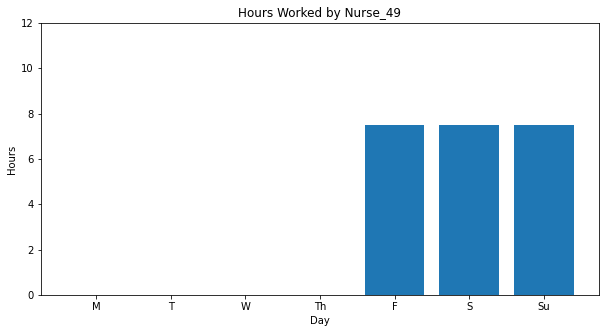

In [187]:
# hours worked (with extra tiny bar if assigned to work, but didn't work any hours)

import matplotlib.pyplot as plt

# Sample data
hh = {n : {d: max(h[n,d].x/60, day_worked[n,d].x/10) for d in D} for n in N}

# Loop over each nurse and create a bar plot
for nurse, days in hh.items():
    if sum(days.values())>1:
        days_list = list(days.keys())
        hours_list = list(days.values())

        plt.figure(figsize=(10, 5))
        plt.bar(days_list, hours_list)
        plt.title(f"Hours Worked by {nurse}")
        plt.xlabel("Day")
        plt.ylabel("Hours")
        plt.ylim(0, 12)  # Assuming a max of 12 hours per day
        plt.show()


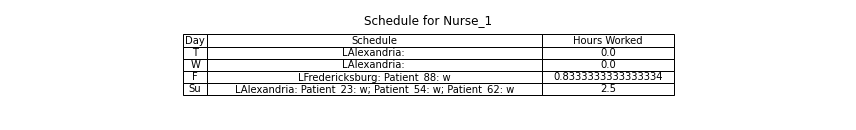

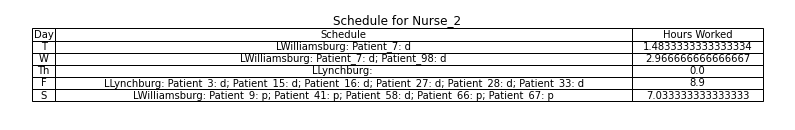

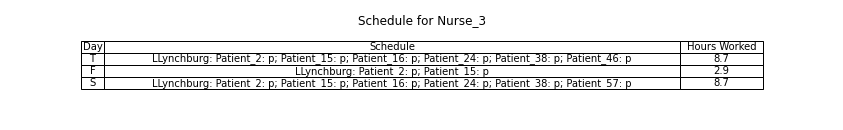

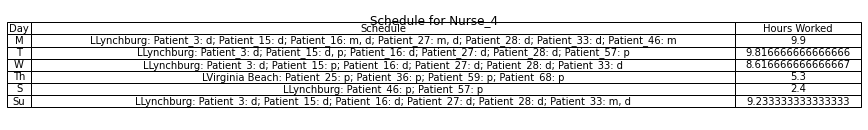

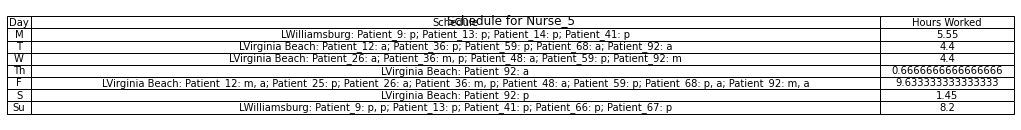

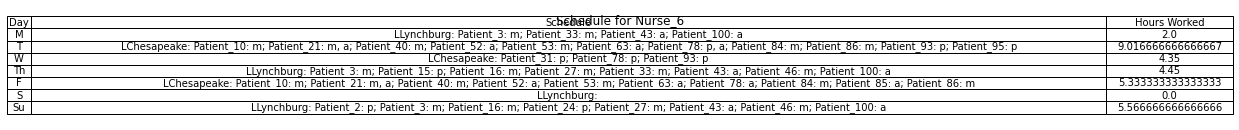

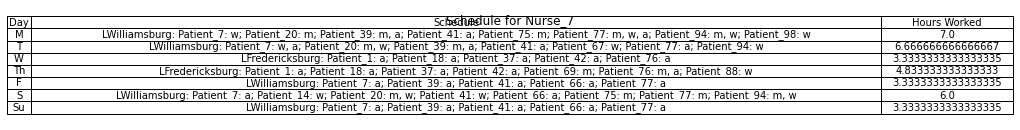

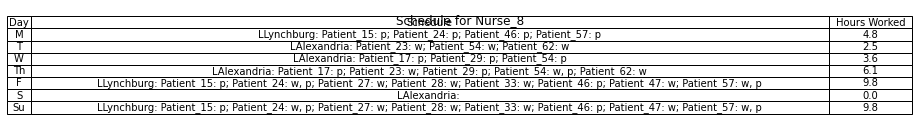

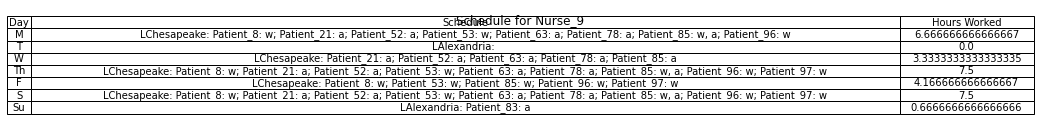

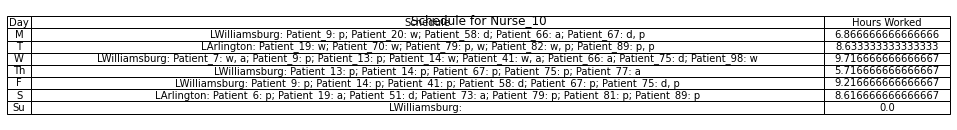

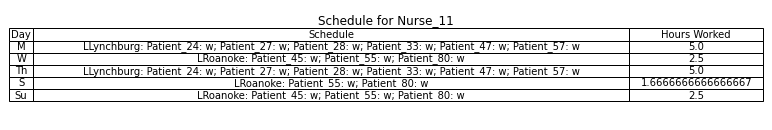

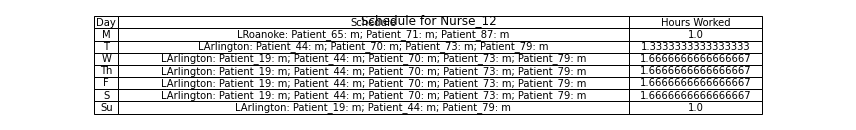

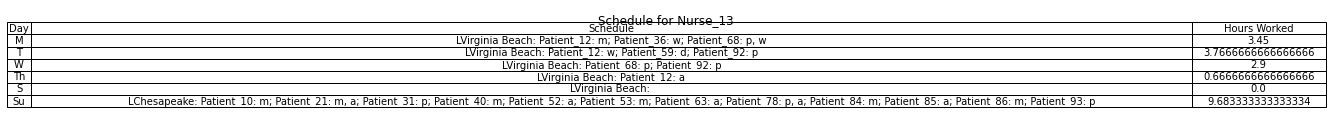

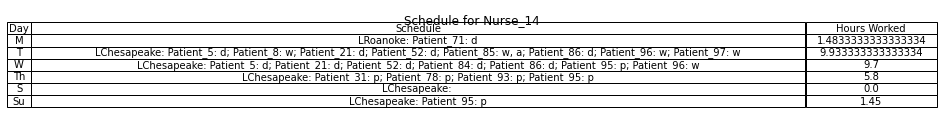

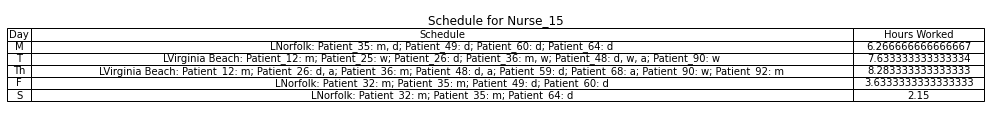

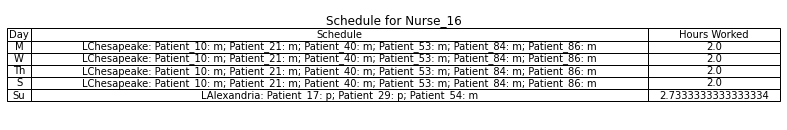

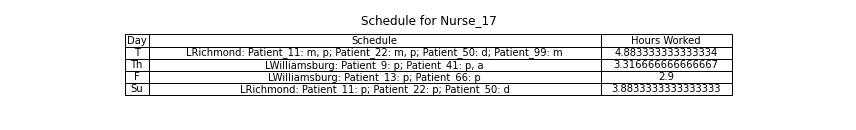

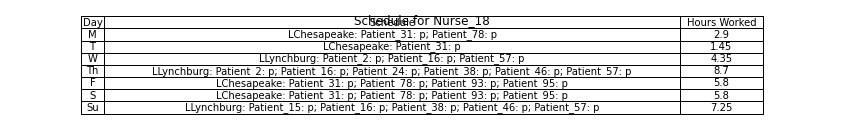

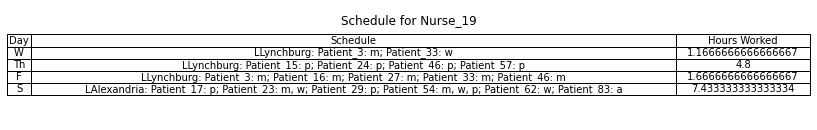

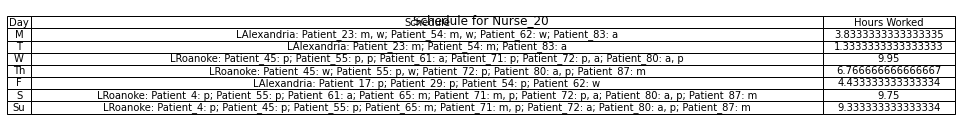

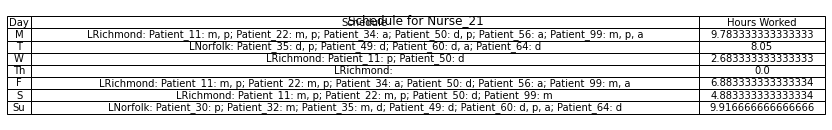

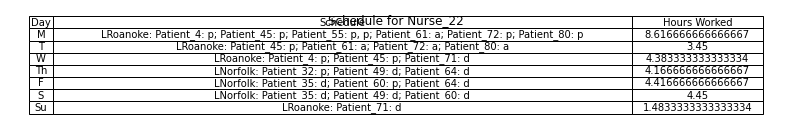

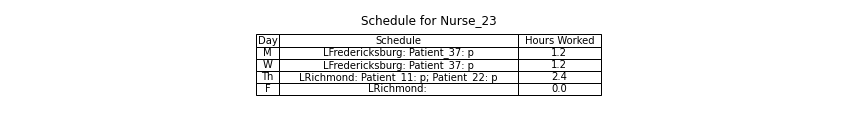

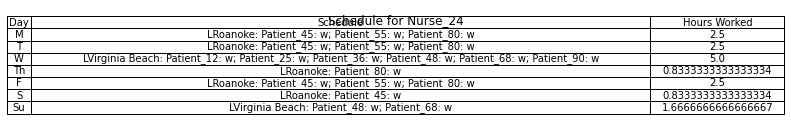

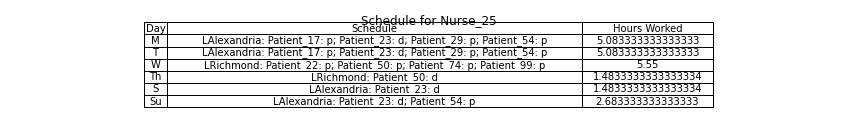

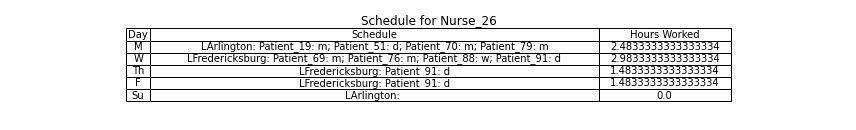

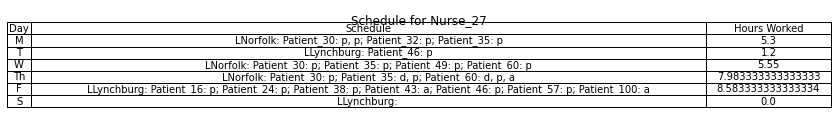

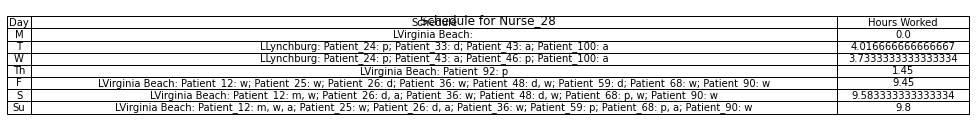

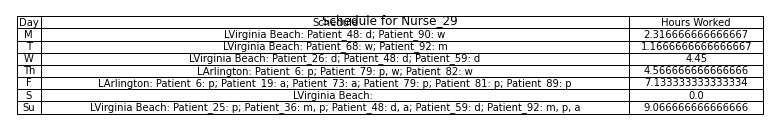

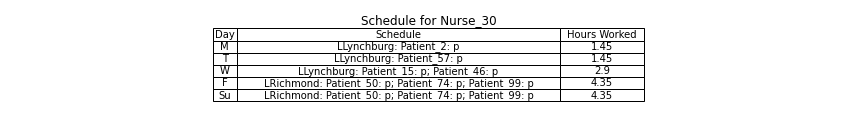

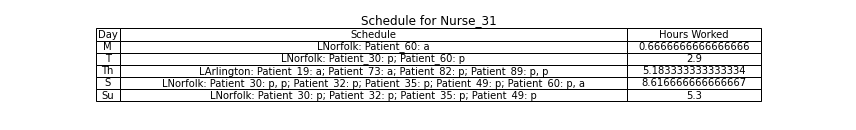

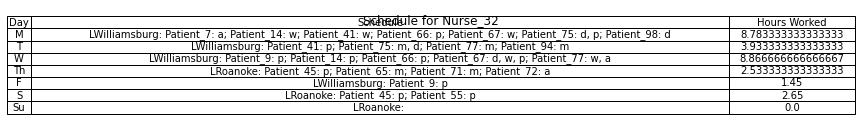

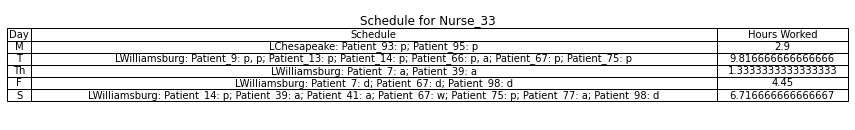

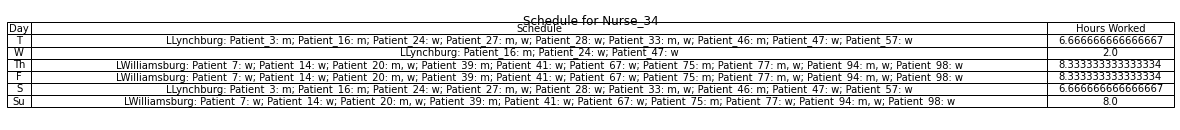

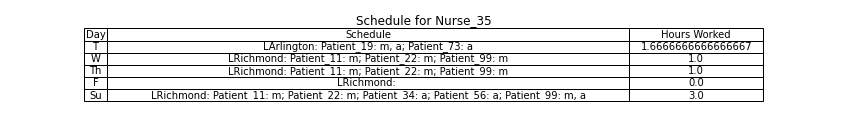

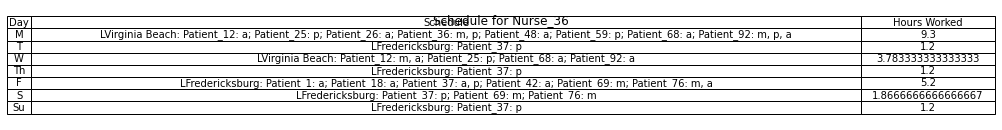

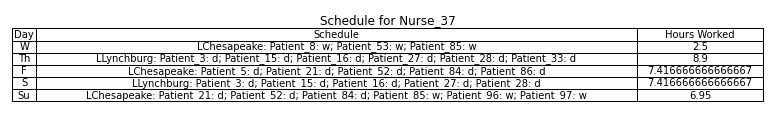

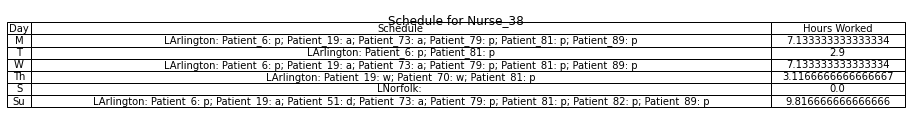

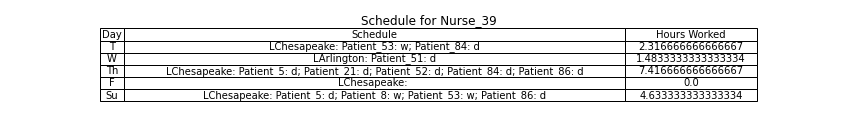

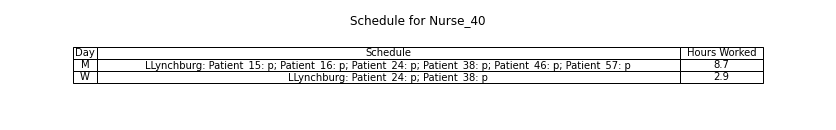

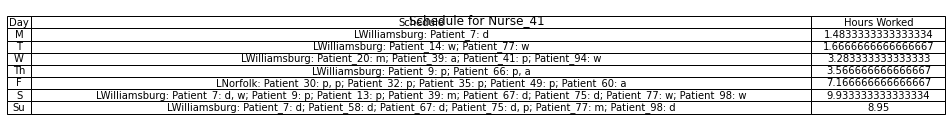

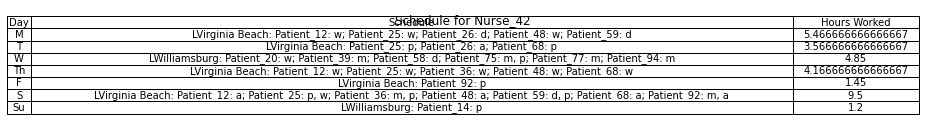

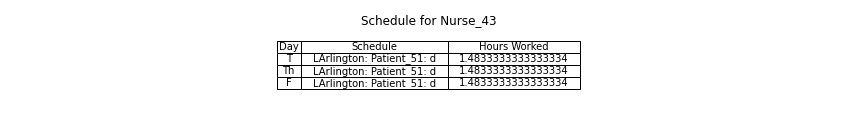

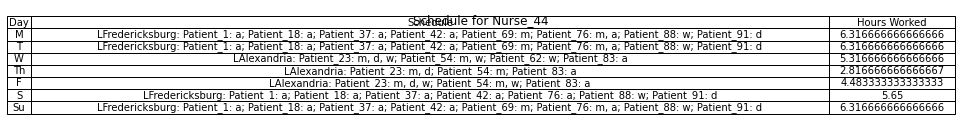

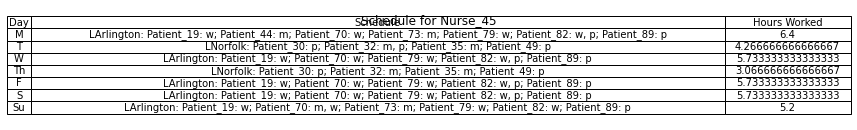

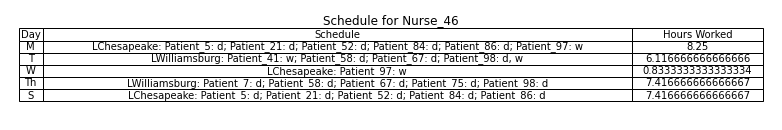

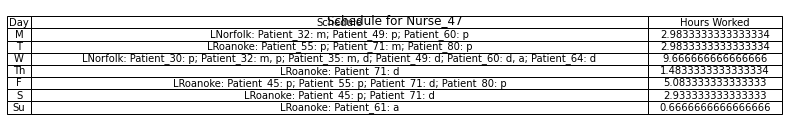

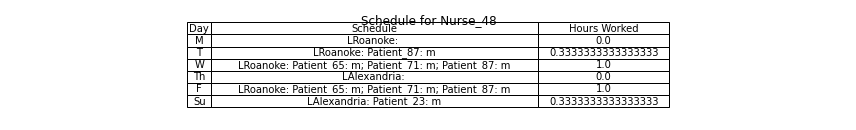

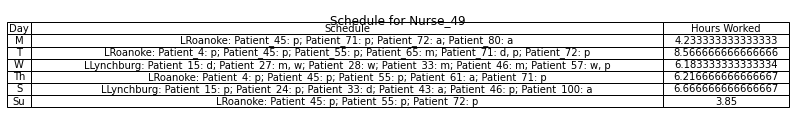

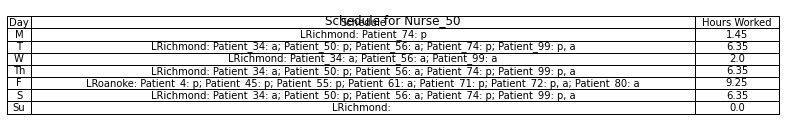

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the solution from the Gurobi model
def extract_schedule(nurse):
    schedule = {}
    for d in D:
        for l in L:
            if y[nurse, l, d].X > 0.5:  # If the nurse is assigned to this location on this day
                patients_tasks = []
                for p in P:
                    tasks = [t for t in T_tasks if x[nurse, d, p, t].X > 0.5]
                    if tasks:
                        task_str = ', '.join([t[0] for t in tasks])  # Abbreviating tasks
                        patients_tasks.append(f"{p}: {task_str}")
                schedule[d] = f"L{l}: {'; '.join(patients_tasks)}"
    return schedule

# Extract the solution from the Gurobi model
def extract_schedule(nurse):
    schedule = {}
    for d in D:
        total_time = 0  # To accumulate the total time for the day
        for l in L:
            if y[nurse, l, d].X > 0.5:  # If the nurse is assigned to this location on this day
                patients_tasks = []
                for p in P:
                    tasks = [t for t in T_tasks if x[nurse, d, p, t].X > 0.5]
                    if tasks:
                        task_str = ', '.join([t[0] for t in tasks])  # Abbreviating tasks
                        patients_tasks.append(f"{p}: {task_str}")
                        total_time += sum(task_time[t] for t in tasks)  # Add the time for each task
                schedule[d] = (f"L{l}: {'; '.join(patients_tasks)}", total_time / 60)  # Convert time to hours
    return schedule

# Plot the schedule for each nurse
for nurse in N:
    data = extract_schedule(nurse)
    # Convert the dictionary to a list of tuples for DataFrame creation
    data_list = [(day, schedule[0], schedule[1]) for day, schedule in data.items()]
    df = pd.DataFrame(data_list, columns=["Day", "Schedule", "Hours Worked"])

    if not df.empty:  # Check if the DataFrame has data
        fig, ax = plt.subplots(1, 1, figsize=(12, len(D)*0.3))  # Adjust the figure size
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
        
        # Adjust cell size
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(df.columns))))
        
        ax.set_title(f"Schedule for {nurse}", y=0.8)  # Adjust title position
        plt.subplots_adjust(top=0.2)  # Reduce top margin
        plt.tight_layout()  # Adjust layout to fit content
        plt.show()
    else:
        print(f"No schedule found for {nurse}")




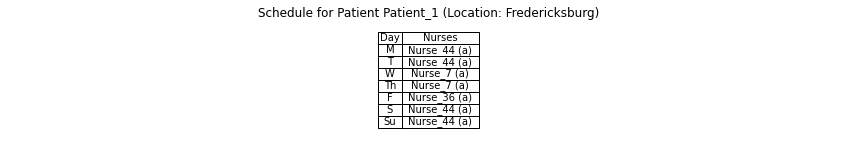

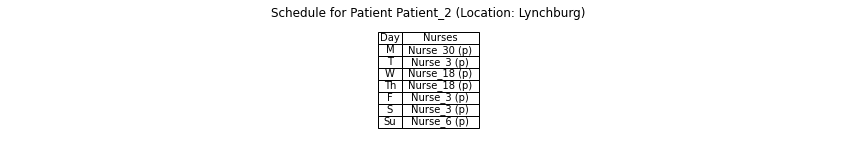

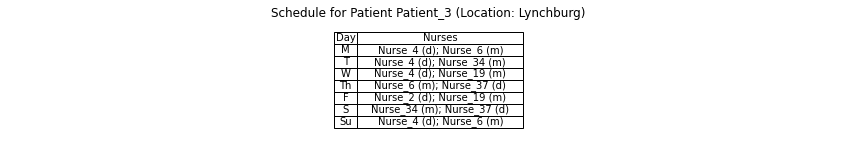

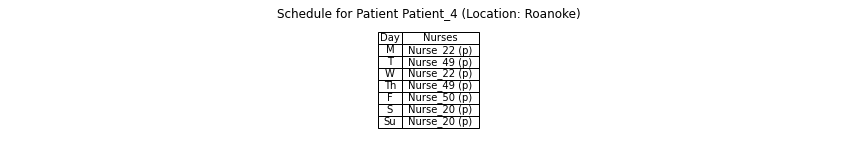

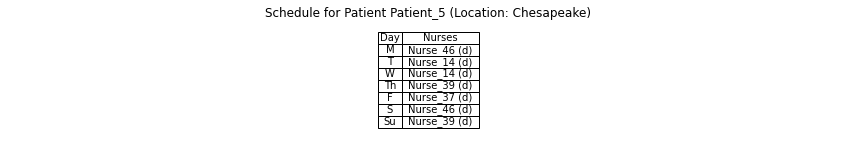

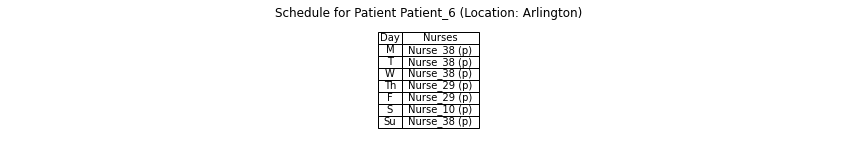

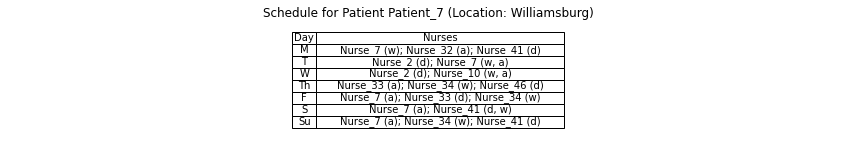

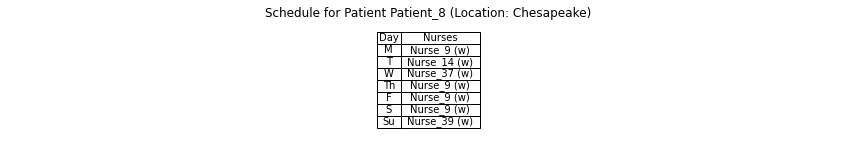

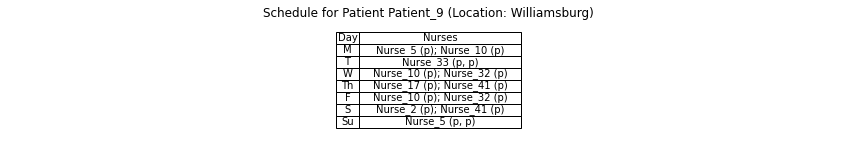

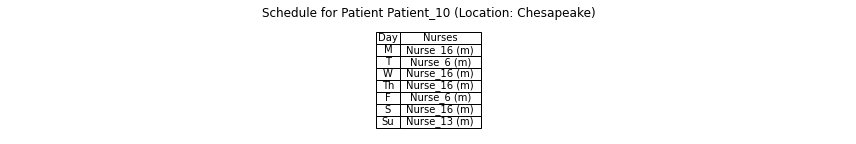

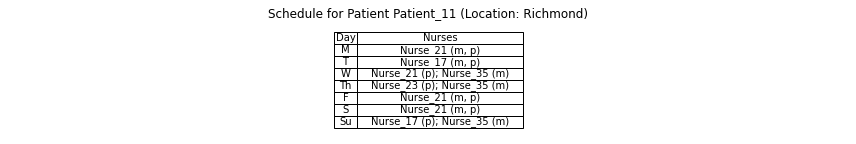

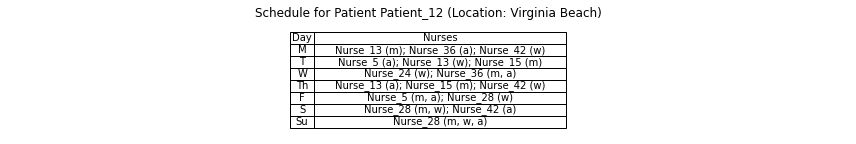

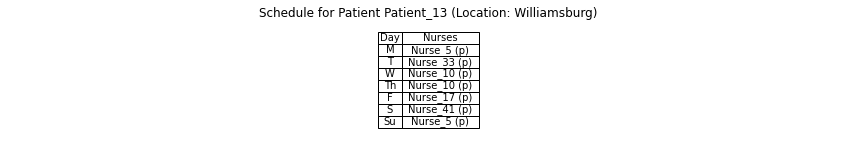

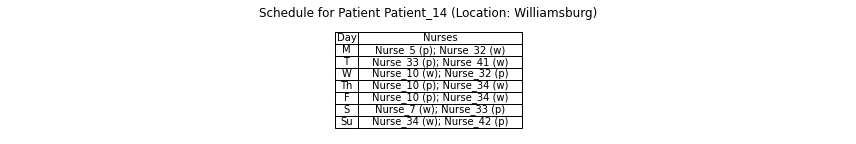

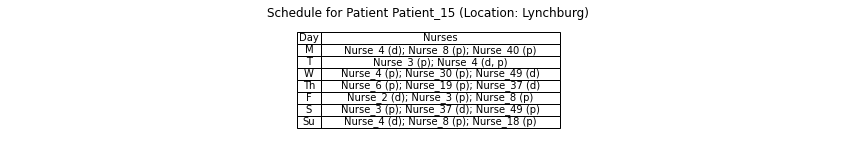

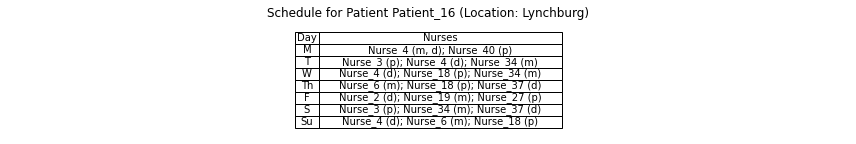

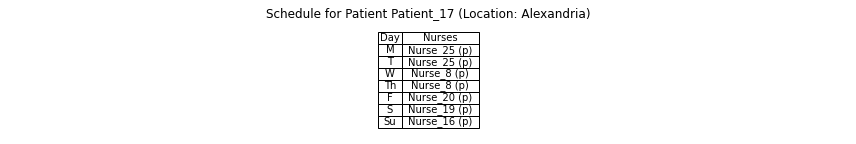

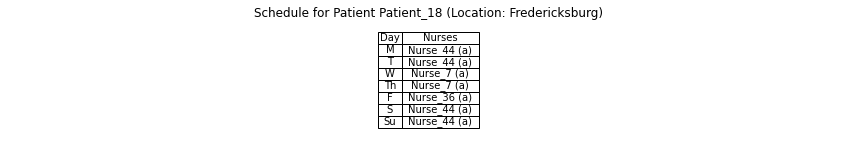

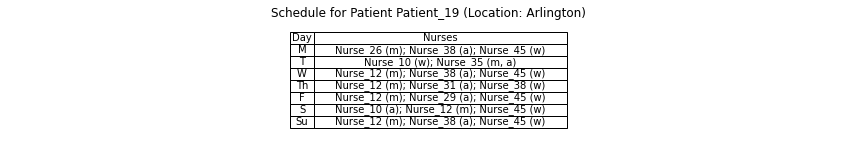

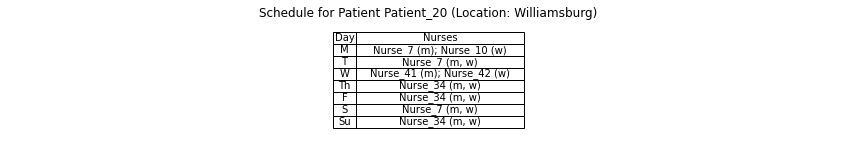

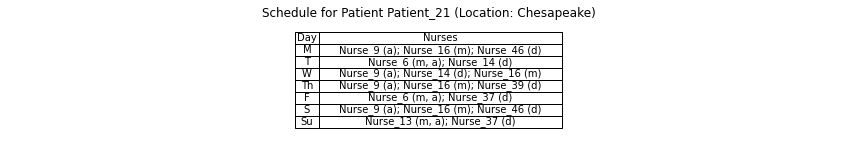

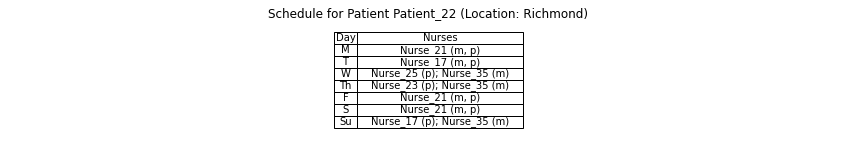

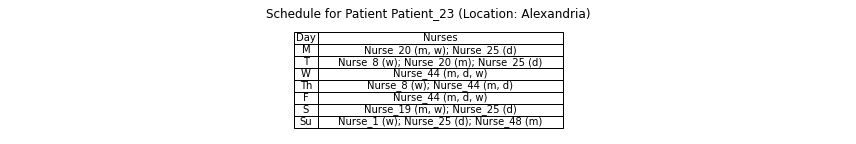

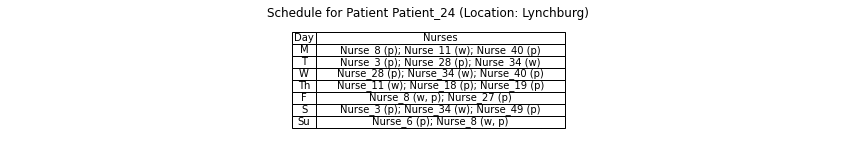

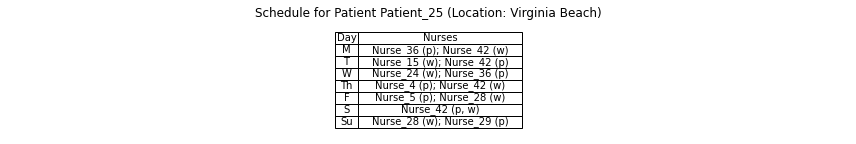

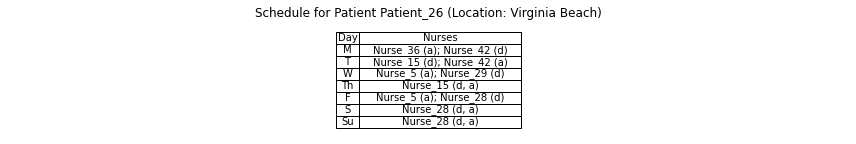

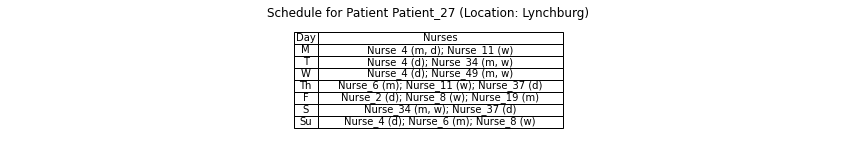

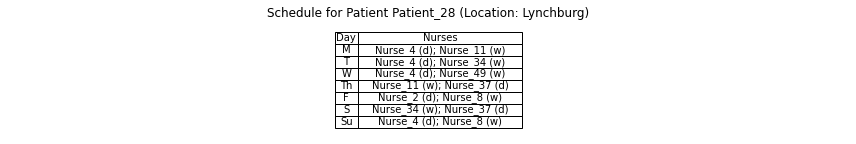

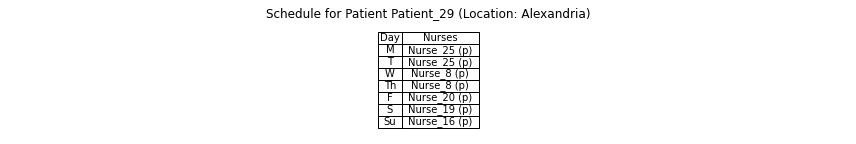

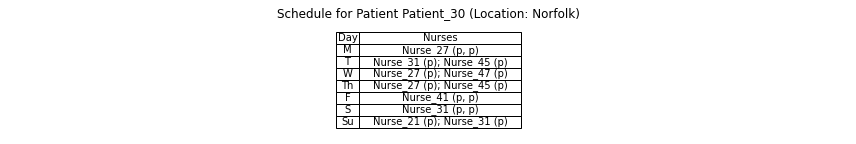

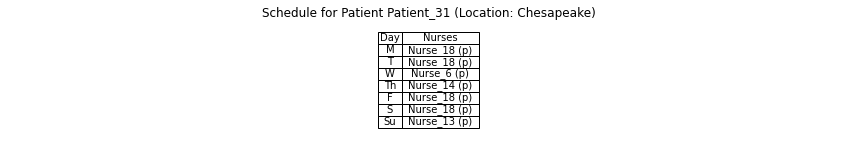

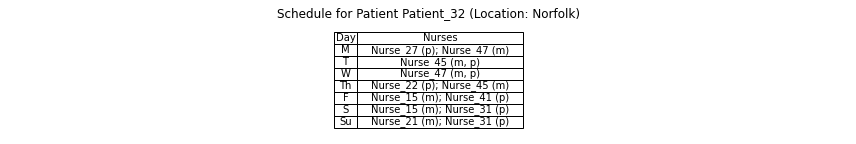

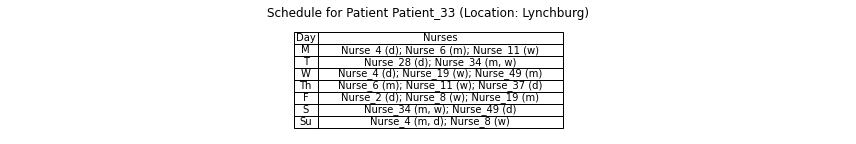

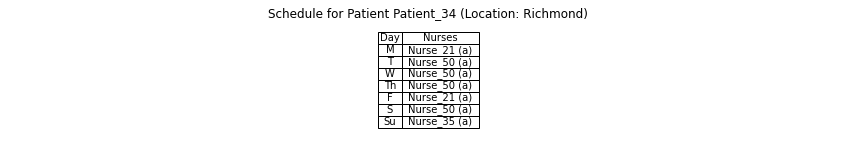

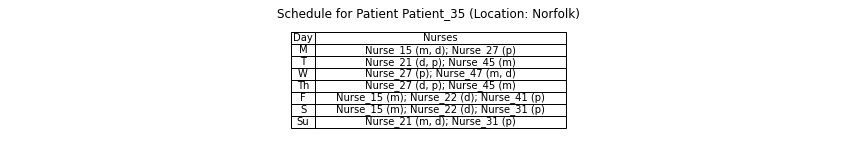

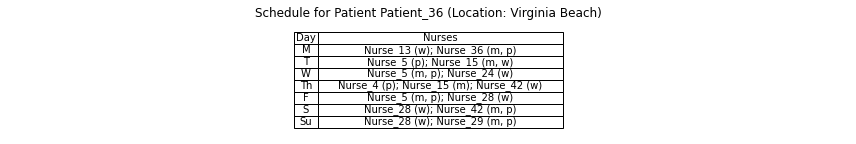

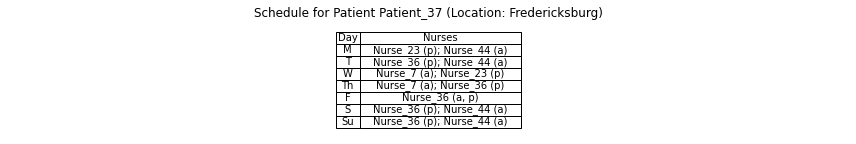

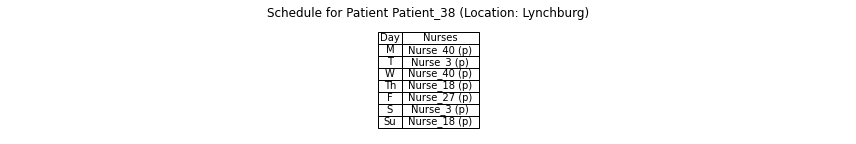

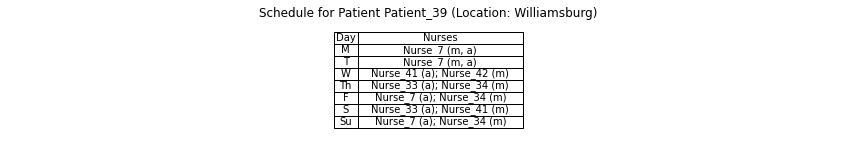

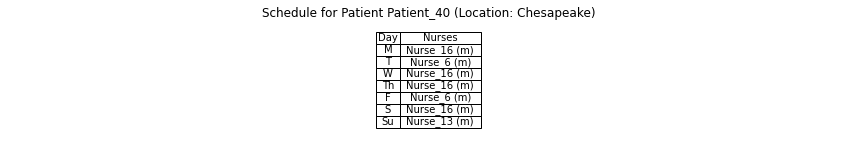

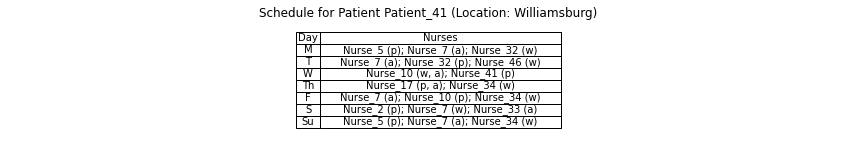

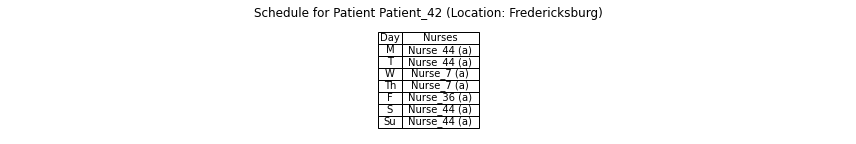

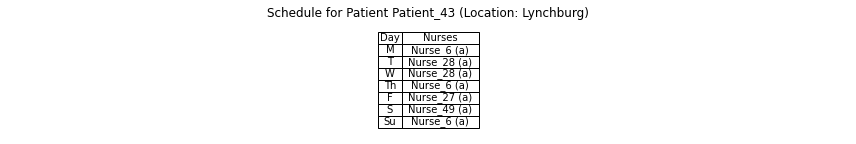

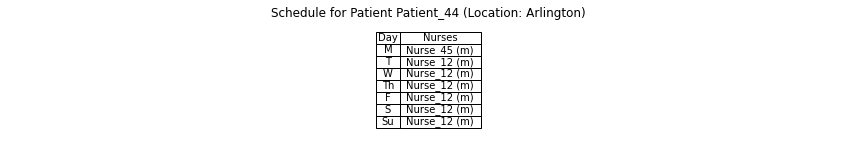

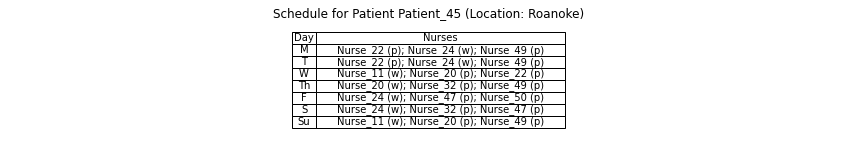

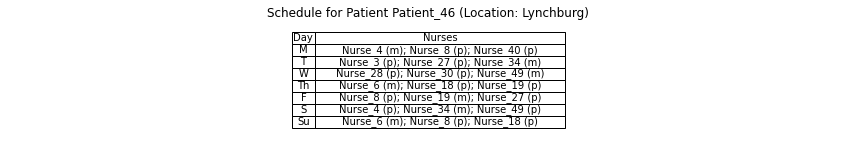

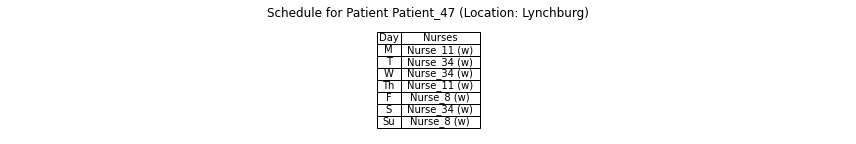

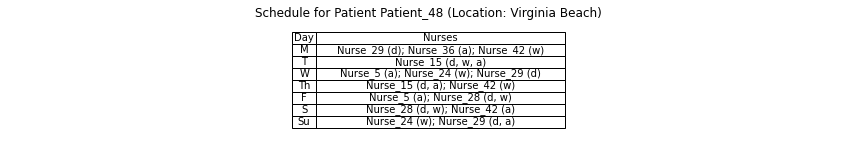

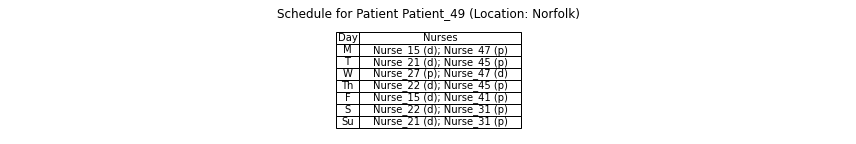

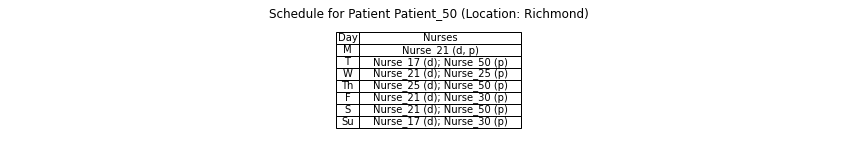

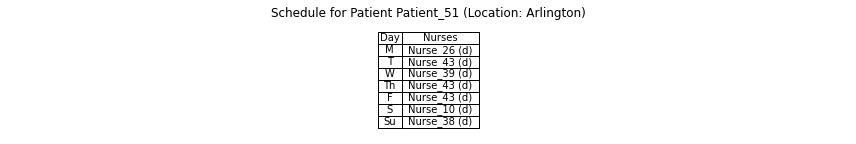

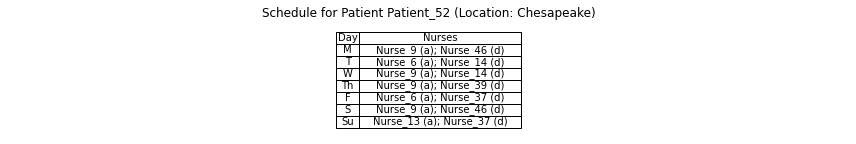

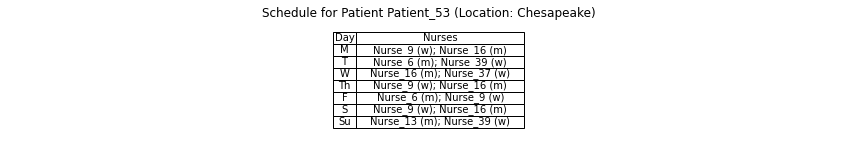

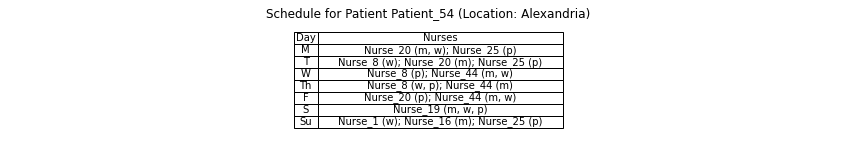

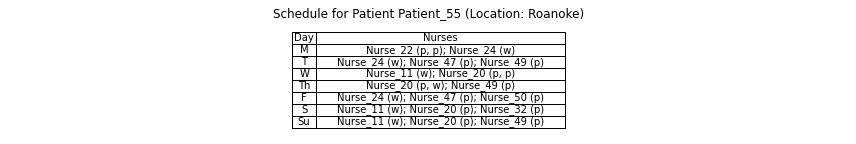

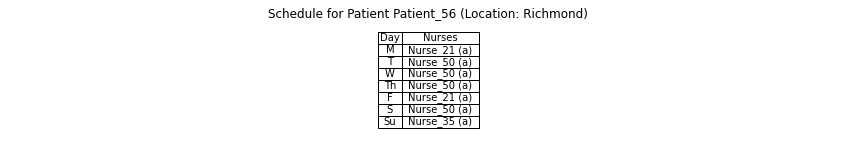

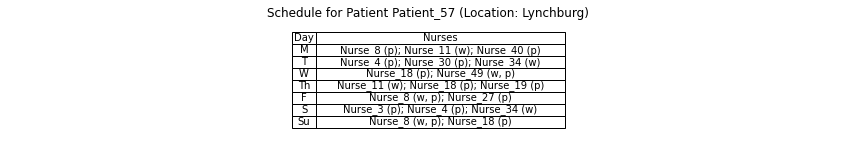

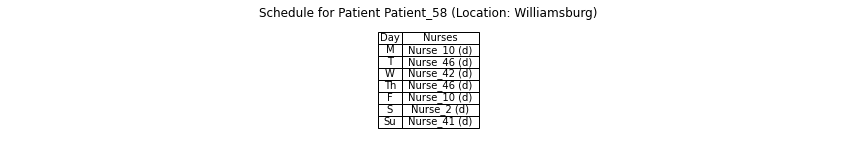

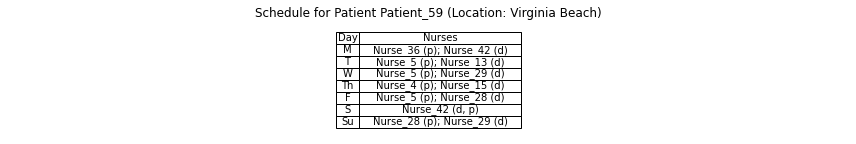

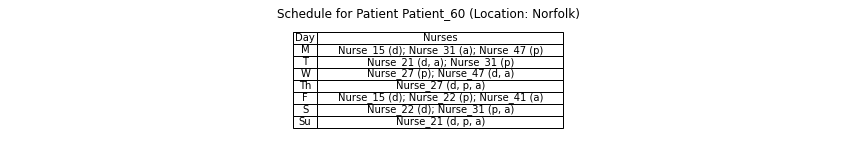

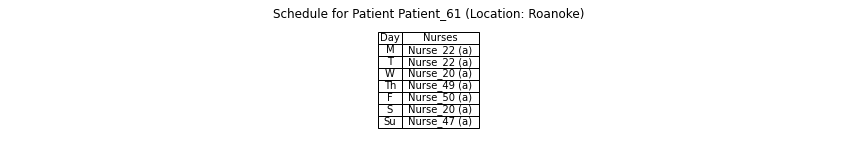

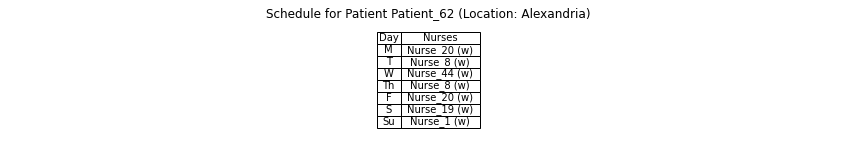

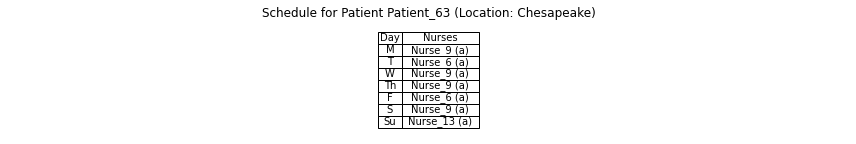

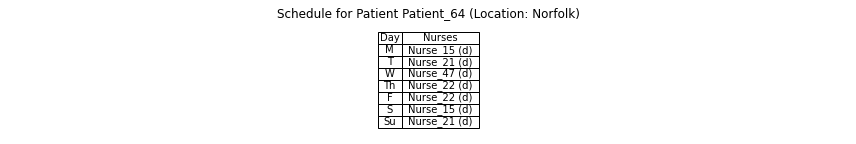

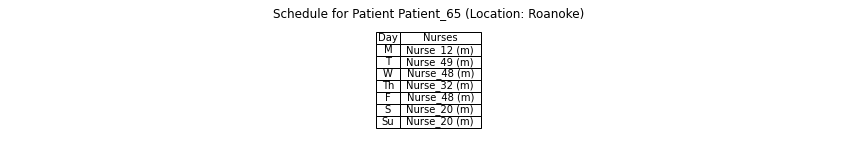

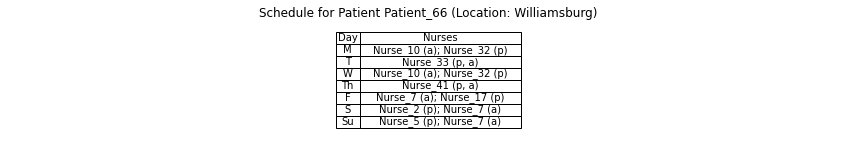

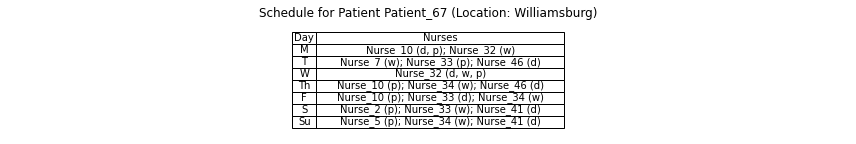

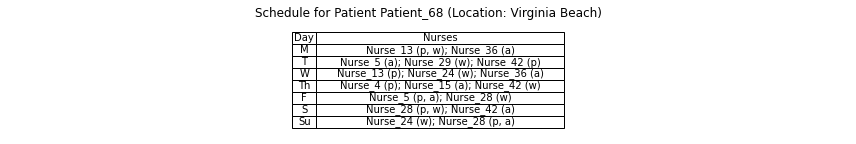

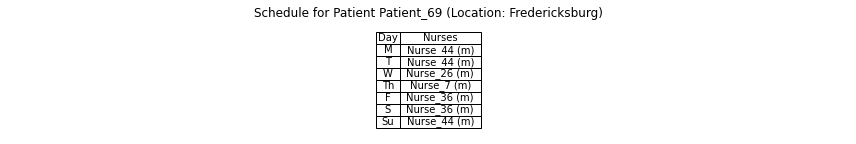

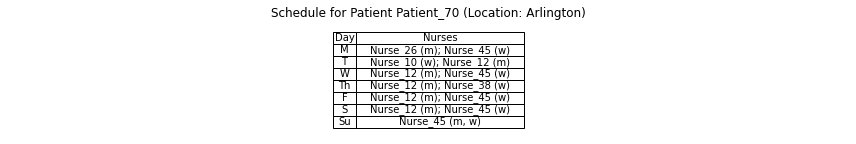

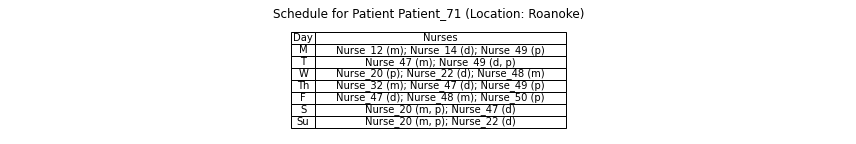

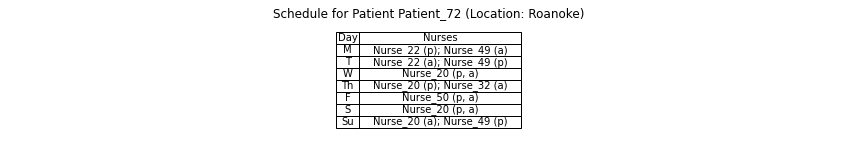

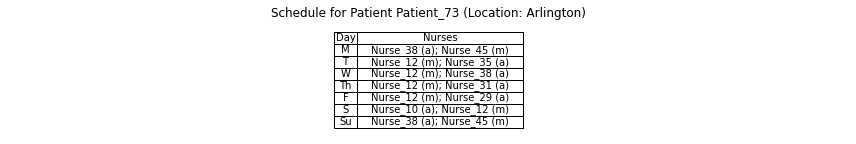

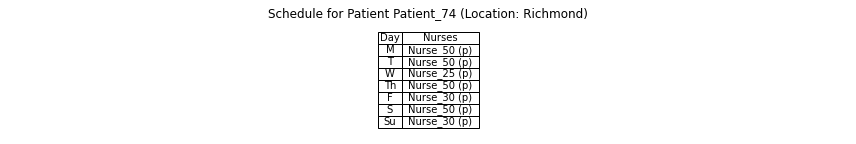

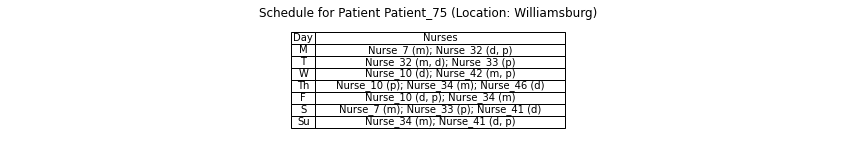

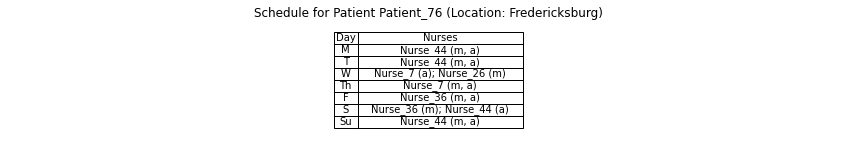

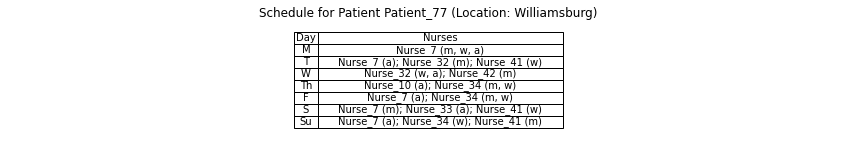

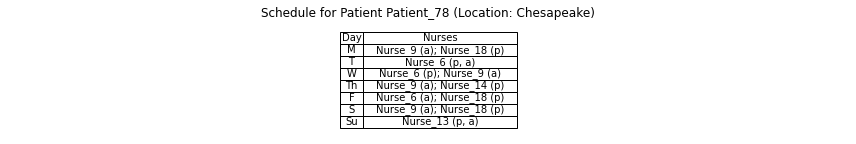

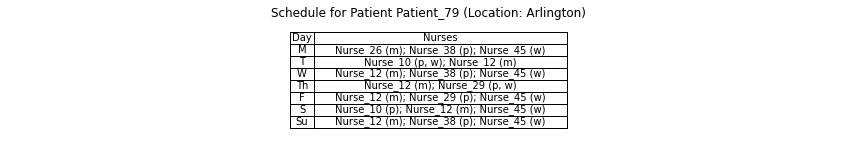

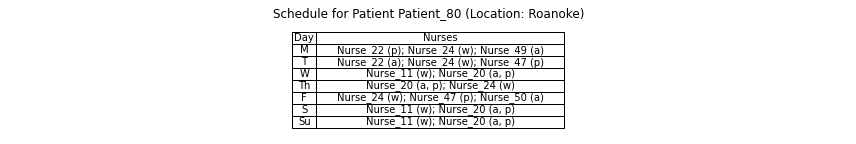

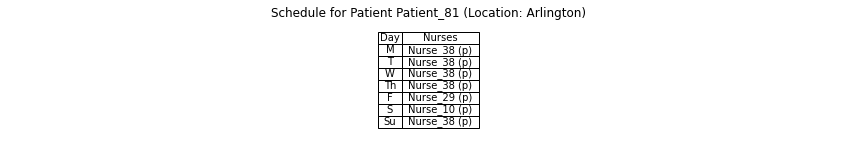

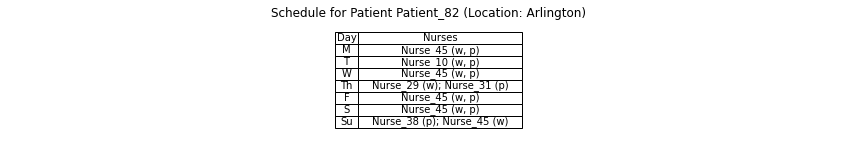

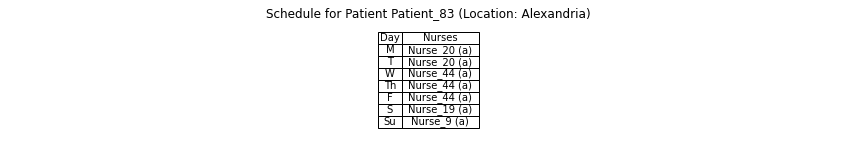

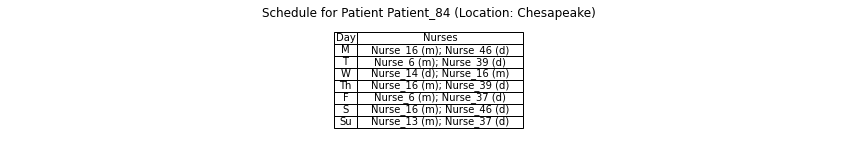

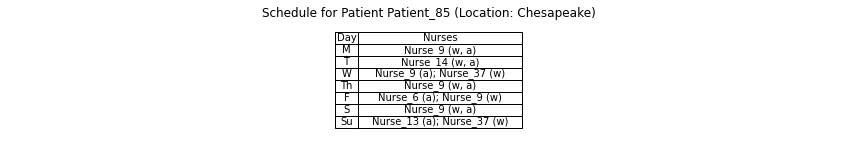

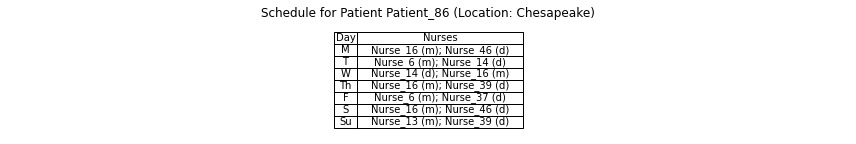

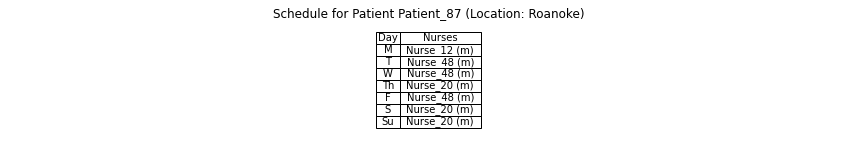

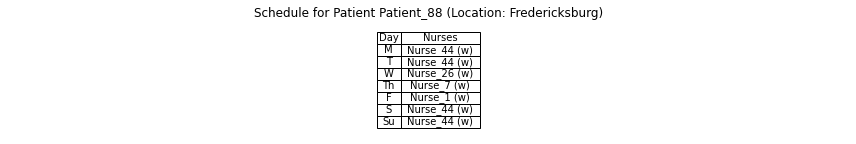

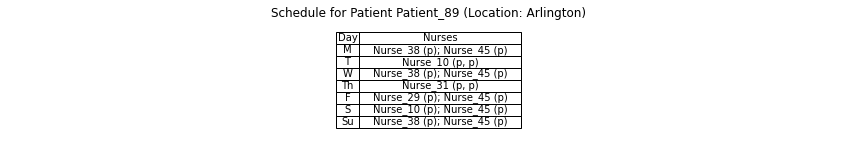

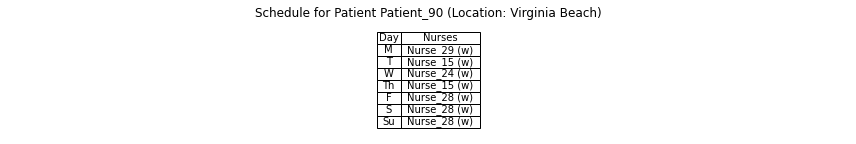

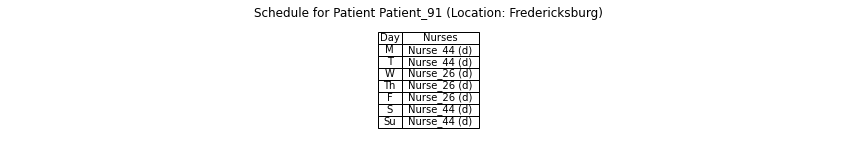

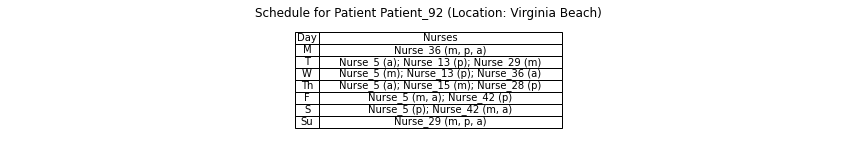

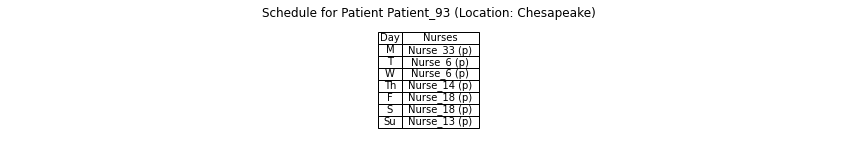

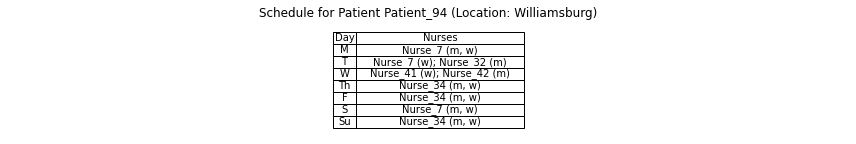

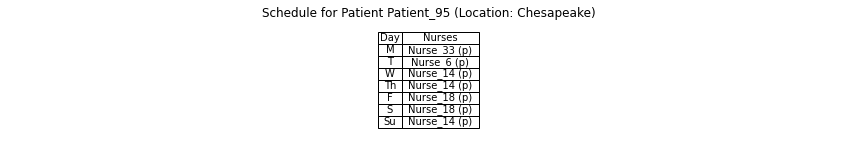

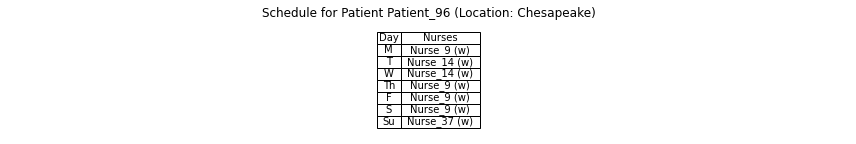

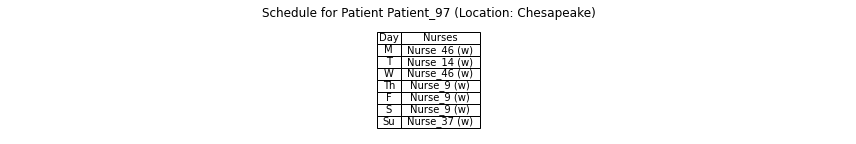

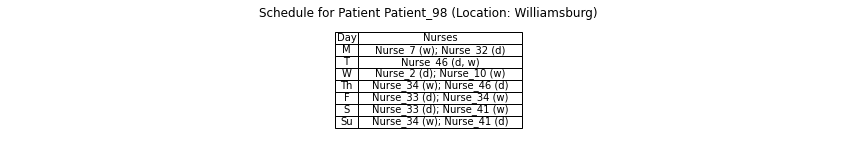

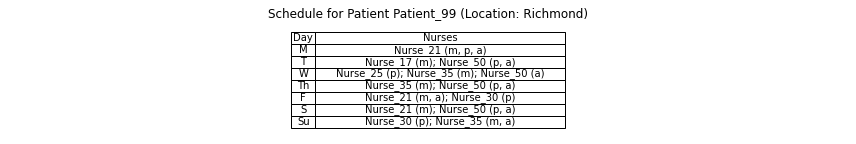

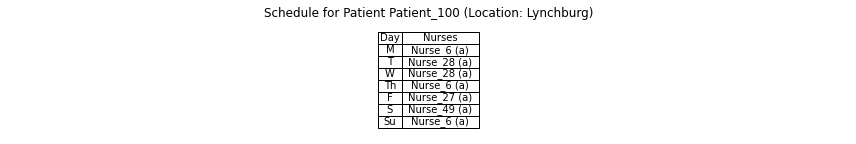

In [19]:
# Extract the schedule for each patient
def extract_patient_schedule(patient):
    schedule = {}
    for d in D:
        nurses_assigned = []
        for n in N:
            tasks = [t for t in T_tasks if x[n, d, patient, t].X > 0.5]
            if tasks:
                nurses_assigned.append(f"{n} ({', '.join([t[0] for t in tasks])})")  # Nurse with abbreviated tasks
        schedule[d] = '; '.join(nurses_assigned)
    return schedule

# Plot the schedule for each patient
for patient in P:
    data = extract_patient_schedule(patient)
    df = pd.DataFrame(list(data.items()), columns=["Day", "Nurses"])

    if not df.empty:  # Check if the DataFrame has data
        fig, ax = plt.subplots(1, 1, figsize=(12, len(D)*0.3))  # Adjust the figure size
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
        
        # Adjust cell size
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(df.columns))))
        
        patient_location = patients_mapping[patient]['location']
        ax.set_title(f"Schedule for Patient {patient} (Location: {patient_location})", y=1.0)  # Adjust title position with location
        plt.subplots_adjust(top=0.5)  # Reduce top margin
        plt.tight_layout()  # Adjust layout to fit content
        plt.show()
    else:
        print(f"No schedule found for Patient {patient}")


In [44]:
import openpyxl

In [45]:
# Extract the solution from the Gurobi model
def extract_schedule(nurse):
    schedule = []
    for d in D:
        total_time = 0  # To accumulate the total time for the day
        location_assigned = ""
        patients_tasks = []
        for l in L:
            if A[nurse, l, d].X > 0.5:  # If the nurse is assigned to this location on this day
                location_assigned = l
                for p in P:
                    tasks = [t for t in T_tasks if X[nurse, d, p, t].X > 0.5]
                    if tasks:
                        task_str = ', '.join([t[0] for t in tasks])  # Abbreviating tasks
                        patients_tasks.append(f"{p}: {task_str}")
                        total_time += sum(task_time[t] for t in tasks)  # Add the time for each task
        schedule.append((d, location_assigned, '; '.join(patients_tasks), total_time / 60))  # Convert time to hours
    return schedule

# Create an Excel writer object
with pd.ExcelWriter('schedules.xlsx', engine='openpyxl') as writer:
    
    # Save nurse schedules to Excel
    all_nurse_schedules = []
    for nurse in N:
        data = extract_schedule(nurse)
        df = pd.DataFrame(data, columns=["Day", "Location", "Patients and Tasks", "Hours Worked"])
        df.insert(0, "Nurse", nurse)  # Add a column for the nurse's name
        all_nurse_schedules.append(df)
    
    if all_nurse_schedules:
        nurse_schedule_df = pd.concat(all_nurse_schedules, ignore_index=True)
        nurse_schedule_df.to_excel(writer, sheet_name='Nurse Schedules', index=False)

    # ... [rest of the code for patient schedules]

print("Schedules saved to schedules.xlsx")



Schedules saved to schedules.xlsx


In [47]:
# Create a text file to write the constraints
model.write('LargeDataSet.lp')

In [51]:
for n in N:
    for d in D:
        if P_var[n,d].X > 0:
            print(n,d)
            print(P_var[n,d].X)